/tmp/ipykernel_7307/1615524965.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'], errors='coerce')
/tmp/ipykernel_7307/1615524965.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['time'] = pd.to_datetime(df2['time'], errors='coerce')


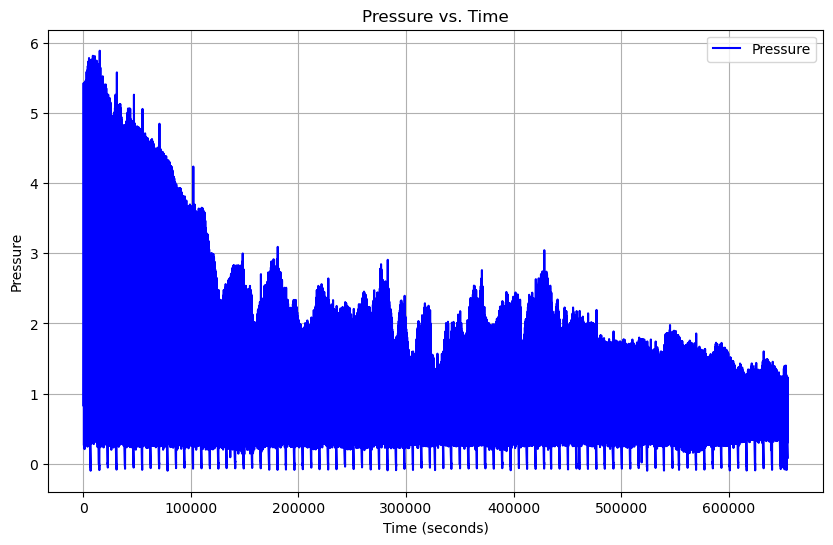

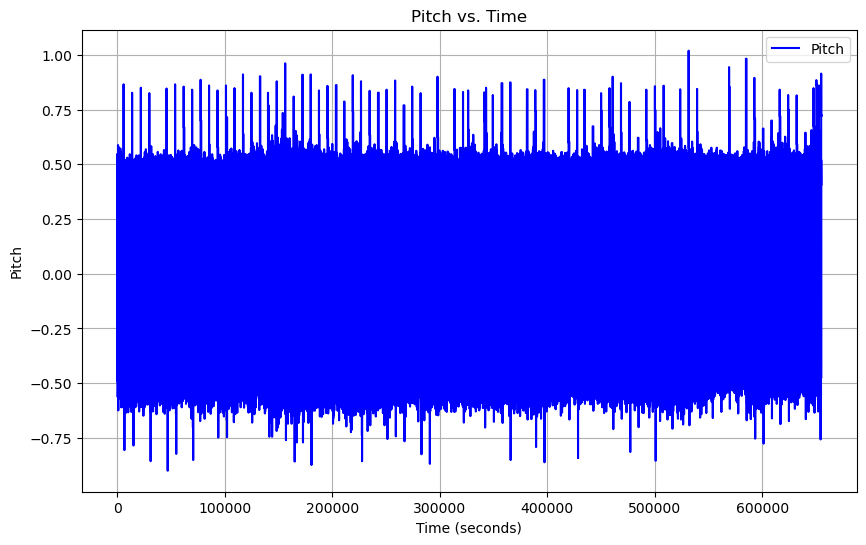

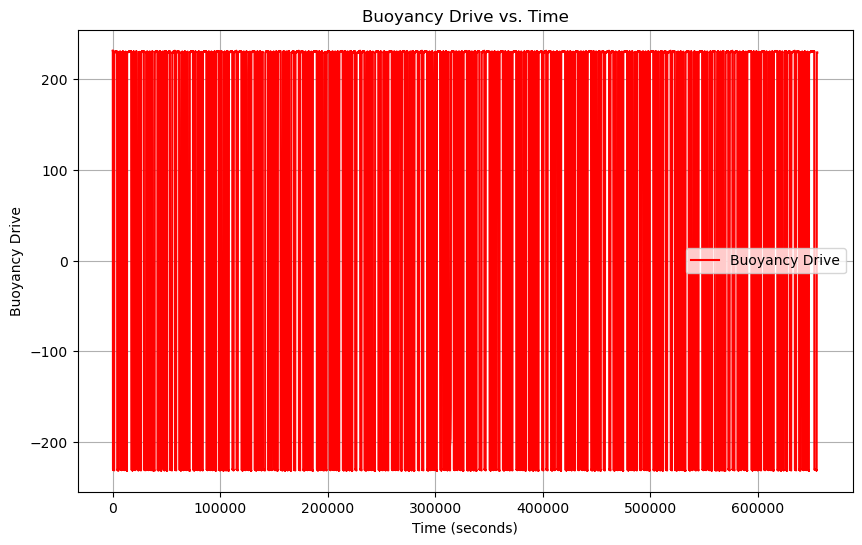

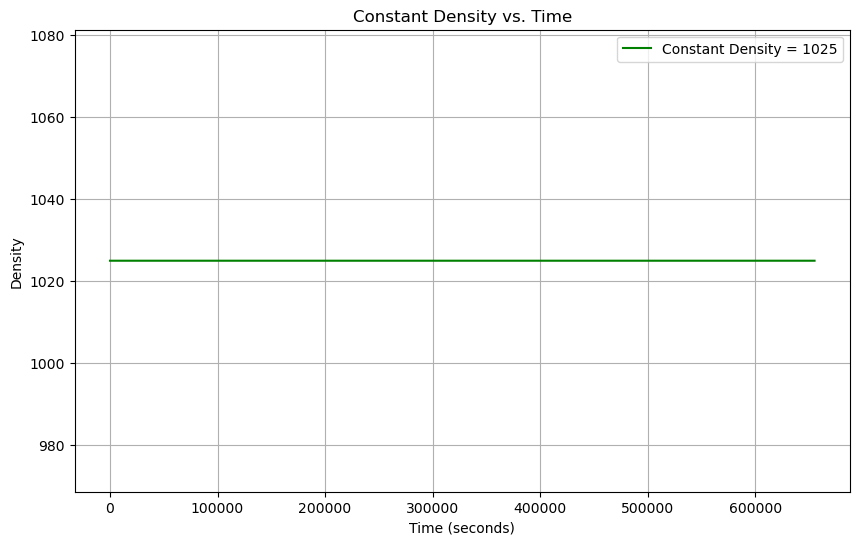

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV files
df = pd.read_csv(
    'maracoos_01-20240124T1612-trajectory-raw-delayed_f099_da4d_91e4.csv',
    low_memory=False  # Prevent mixed type warning
)

df2 = pd.read_csv(
    'maracoos_01-20240124T1612-profile-sci-delayed_20f3_260a_197e.csv',
    low_memory=False  # Prevent mixed type warning
)

tctd, P, pitch, buoyancy_drive, density, U_adcp = np.load("./data/gliderflight_data.npy")

# Convert 'time' column to datetime, specify format if known
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Drop rows where 'time' could not be parsed or 'm_pitch'/'m_pressure' are NaN
df.dropna(subset=['time', 'm_pitch', 'm_pressure'], inplace=True)

# Convert 'time' column to datetime, specify format if known
df2['time'] = pd.to_datetime(df2['time'], errors='coerce')

# Drop rows where 'time' could not be parsed or 'density' are NaN
df2.dropna(subset=['time', 'density'], inplace=True)

# Convert time to seconds since the first timestamp
df['time_seconds'] = (df['time'] - df['time'].iloc[0]).dt.total_seconds()
df2['time_seconds'] = (df2['time'] - df2['time'].iloc[0]).dt.total_seconds()

# Transform columns to float type
df['time_seconds'] = df['time_seconds'].astype(float)
df['m_pitch'] = df['m_pitch'].astype(float)
df['m_pressure'] = df['m_pressure'].astype(float)

df2['time_seconds'] = df2['time_seconds'].astype(float)
df2['density'] = df2['density'].astype(float)

# Convert the selected columns to a NumPy array
array_data = df[['time_seconds', 'm_pitch', 'm_pressure', 'time']].to_numpy()
array_data2 = df2[['time_seconds', 'density']].to_numpy()

tctd = array_data[:,0]
P = array_data[:,2]
Pitch = array_data[:,1]
buoyancy_drive = np.resize(buoyancy_drive, len(array_data))
# Generate a constant density vector with the same length as array_data
density = 1025 * np.ones(len(array_data))

# Plot Pressure vs. Time
plt.figure(figsize=(10, 6))
plt.plot(tcdt, P, label='Pressure', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Pressure')
plt.title('Pressure vs. Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Pitch vs. Time
plt.figure(figsize=(10, 6))
plt.plot(tcdt, Pitch, label='Pitch', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch')
plt.title('Pitch vs. Time')
plt.legend()
plt.grid(True)
plt.show()


# Ensure buoyancy_drive is the same length as array_data


# Plot Buoyancy Drive vs. Time
plt.figure(figsize=(10, 6))
plt.plot(tcdt, buoyancy_drive, label='Buoyancy Drive', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Buoyancy Drive')
plt.title('Buoyancy Drive vs. Time')
plt.legend()
plt.grid(True)
plt.show()



# Plot the constant density vector vs. Time
plt.figure(figsize=(10, 6))
plt.plot(tcdt, density, label='Constant Density = 1025', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Density')
plt.title('Constant Density vs. Time')
plt.legend()
plt.grid(True)
plt.show()




In [35]:
print(tctd.size)

13140


In [31]:
import numpy as np
import sys
sys.path.insert(0, '..')
import gliderflight
import matplotlib.pyplot as plt
# Setup a steady-state model to calibrate
GM = gliderflight.SteadyStateCalibrate(rho0=1004)  # rho0 might be the initial density.
GM.define(ah=3.8, Cd1=10.5)    # ah: lift angle coefficient due to the hull (1/rad);  Cd1 is induced drag coefficient (1/rad²)
GM.set_input_data(time=tctd, pressure=P, pitch=Pitch, buoyancy_change=buoyancy_drive, density=density)
# GM.OR(P*10<10)
# GM.OR(P*10>35)
GM.define(Cd0=0.15, mg=60, Vg=52/1004)   # Cd0 is the parasite drag coefficient; mg: mass of the glider (kg); Vg: volume of the glider (m³)
calibration_result = GM.calibrate("Cd0", "mg", verbose=True)

ValueError: operands could not be broadcast together with shapes (148787,) (13140,) 

In [ ]:
df['time_seconds'].astype(float)

4              0.0
9              4.0
14             8.0
19            12.0
24            16.0
            ...   
791935    654651.0
791940    654655.0
791945    654659.0
791950    654664.0
792317    655102.0
Name: time_seconds, Length: 148787, dtype: float64